In [1]:
import warnings
warnings.filterwarnings("ignore") 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

import re
import numpy as np
import seaborn as sns
import os
import pandas as pd
from shutil import copyfile
from tqdm import tqdm

import keras
from keras.models import Sequential, load_model,Model
from keras.layers import Dense, Dropout, Activation,ReLU,Flatten, Conv2D, MaxPooling2D,BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
from keras import regularizers
import tensorflow as tf
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau,CSVLogger
from keras .preprocessing.image import ImageDataGenerator

from PIL import Image
import numpy as np
from skimage import transform

In [2]:
data_dir = "C:/Users/Vijaya/Tomato_dataset/raw/color/"

In [3]:
classes = os.listdir(data_dir)

In [4]:
classes

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']

In [5]:
image_counts = {}
for c in classes:
    try:
        path = data_dir + c
        count = len(os.listdir(path))
        image_counts[c] = count
    except:
        pass
df=pd.DataFrame.from_dict(image_counts, orient = 'index')
df

,0
Tomato___Bacterial_spot,2127
Tomato___Early_blight,1000
Tomato___healthy,1591
Tomato___Late_blight,1909
Tomato___Leaf_Mold,952
Tomato___Septoria_leaf_spot,1771
Tomato___Spider_mites Two-spotted_spider_mite,1676
Tomato___Target_Spot,1404
Tomato___Tomato_mosaic_virus,373
Tomato___Tomato_Yellow_Leaf_Curl_Virus,5357


In [6]:
df=[]
for label, class_name in enumerate(classes):
    path = data_dir + class_name
    for file in os.listdir(path):
        df.append(['{}/{}'.format(class_name, file), label, class_name])
        
df = pd.DataFrame(df, columns=['file', 'label', 'class_name'])

In [7]:
df.head()

,file,label,class_name
0,Tomato___Bacterial_spot/00416648-be6e-4bd4-bc8...,0,Tomato___Bacterial_spot
1,Tomato___Bacterial_spot/0045ba29-ed1b-43b4-afd...,0,Tomato___Bacterial_spot
2,Tomato___Bacterial_spot/00639d29-2d1a-4fcf-9bd...,0,Tomato___Bacterial_spot
3,Tomato___Bacterial_spot/00728f4d-83a0-49f1-87f...,0,Tomato___Bacterial_spot
4,Tomato___Bacterial_spot/00a7c269-3476-4d25-b74...,0,Tomato___Bacterial_spot


In [8]:
import re
def read_img(filepath, size):
    img = image.load_img(data_dir + filepath, target_size=size)
    img = image.img_to_array(img)
    return img
def format_name(s):
    return re.sub('-+','', s)

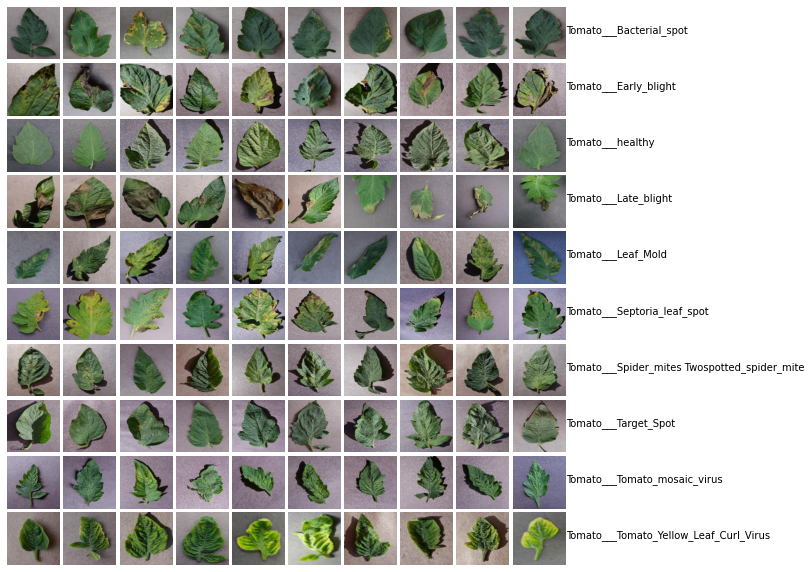

In [9]:
from matplotlib import pyplot as plt
num_classes = len(classes)
fig = plt.figure(1, figsize=(10, 40))
grid = ImageGrid(fig, 111, nrows_ncols = (num_classes, 10), axes_pad=0.05)

i = 0
for label, class_name in enumerate(classes):
    for filepath in df['file'][df['class_name'] == class_name].values[:10]:
        ax = grid[i]
        img = read_img(filepath, (256, 256))
        ax.imshow(img / 255)
        ax.axis('off')
        if i % 10 == 10 - 1:
            name = format_name(filepath.split('/') [0])
            ax.text(260, 112, name, verticalalignment='center')
        i+= 1
        
        
plt.show()

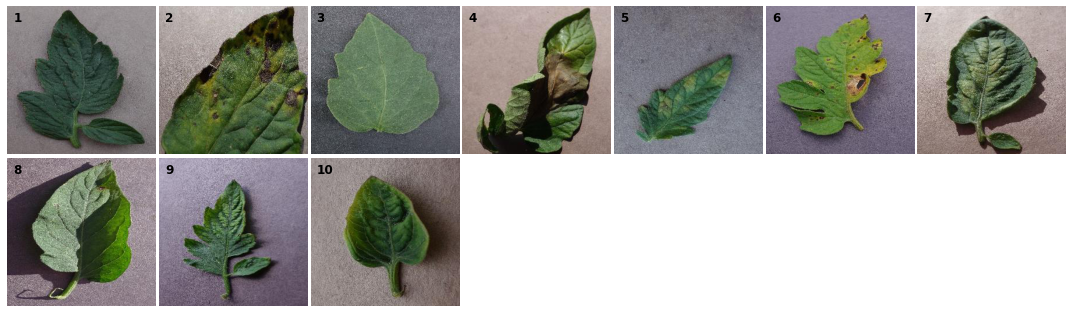

In [10]:
fig = plt.figure(1, figsize = (15, 10))
grid = ImageGrid(fig, 111, nrows_ncols = (6, 7), axes_pad=0.05)


for i in range (42):
    
        ax = grid[i]
        ax.axis('off')
        if i < len(classes):
            class_name = classes[i]
            for filepath in df[df['class_name'] == class_name]['file'].values[:1]:
                img = read_img(filepath, (256, 256))
                ax.imshow(img / 255)
        
                ax.annotate(i+1, xy=(10,25), color="black", fontsize=12, fontweight='bold')
        
plt.tight_layout()

In [11]:
dat_dir ="C:/Users/Vijaya/PlantVillage-Dataset/raw/color/"
classes = os.listdir(data_dir)
num_classes = len(classes)
print("Number of classes:",num_classes)
os.mkdir(data_dir+'train')
os.mkdir(data_dir+'test')

for c in classes:
    os.mkdir(data_dir+'train/' + c)
    os.mkdir(data_dir+'test/' + c)
    
    
    
df = []
for label, class_name in enumerate(classes):
    path = data_dir + class_name
    for file in os.listdir(path):
        df.append(['{}/{}'.format(class_name, file), label, class_name])
        
df = pd.DataFrame(df, columns=['file', 'label', 'class_name'])

num_images = len(df)

print("number of images",num_images)

Number of classes: 10
number of images 18160


In [12]:
df.head()

,file,label,class_name
0,Tomato___Bacterial_spot/00416648-be6e-4bd4-bc8...,0,Tomato___Bacterial_spot
1,Tomato___Bacterial_spot/0045ba29-ed1b-43b4-afd...,0,Tomato___Bacterial_spot
2,Tomato___Bacterial_spot/00639d29-2d1a-4fcf-9bd...,0,Tomato___Bacterial_spot
3,Tomato___Bacterial_spot/00728f4d-83a0-49f1-87f...,0,Tomato___Bacterial_spot
4,Tomato___Bacterial_spot/00a7c269-3476-4d25-b74...,0,Tomato___Bacterial_spot


In [13]:
tr_size=0.8
np.random.seed(50)
num = np.random.binomial(1,tr_size, num_images)

i=0
for file in tqdm(df['file'].values):
    
    from_path = data_dir + file
    if num[i] == 1:
        to_path = data_dir +'train/' +file
    else:
        to_path = data_dir +'test/' +file
        
    copyfile(from_path,to_path)
    i+= 1

100%|███████████████████████████████████████████████████████████████████████████| 18160/18160 [00:50<00:00, 362.21it/s]


In [14]:
TRAIN_DIR = "C:/Users/Vijaya/Tomato_dataset/raw/color/train/"
TEST_DIR = "C:/Users/Vijaya/Tomato_dataset/raw/color/test/"

In [15]:
classes

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']

In [16]:
df = []
for label, class_name in enumerate(classes):
    path = TRAIN_DIR + class_name
    for file in os.listdir(path):
        df.append(['{}/{}'.format(class_name, file), label, class_name, 1])
        
        
    path= TEST_DIR + class_name
    for file in os.listdir(path):
        df.append(['{}/{}'.format(class_name, file), label, class_name, 0])
        
df = pd.DataFrame(df, columns=['file', 'label', 'class_name','train_ind'])

num_train_samples = df.train_ind.sum()
num_test_samples = len(df) - num_train_samples

print("number of train images",num_train_samples)
print("number of test images",num_test_samples)

number of train images 14496
number of test images 3664


In [17]:
df.head()

,file,label,class_name,train_ind
0,Tomato___Bacterial_spot/00416648-be6e-4bd4-bc8...,0,Tomato___Bacterial_spot,1
1,Tomato___Bacterial_spot/0045ba29-ed1b-43b4-afd...,0,Tomato___Bacterial_spot,1
2,Tomato___Bacterial_spot/00639d29-2d1a-4fcf-9bd...,0,Tomato___Bacterial_spot,1
3,Tomato___Bacterial_spot/00728f4d-83a0-49f1-87f...,0,Tomato___Bacterial_spot,1
4,Tomato___Bacterial_spot/00a7c269-3476-4d25-b74...,0,Tomato___Bacterial_spot,1


In [18]:
#from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3, preprocess_input
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                  height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [19]:
width,height,depth = 299, 299, 3
batch = 64
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(width,height),
    batch_size=batch)
    
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(width,height),
    batch_size=batch,
    shuffle=False
    )

Found 14496 images belonging to 10 classes.
Found 3664 images belonging to 10 classes.


In [21]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.5) (x)
output = Dense(10, activation='softmax') (x)
model = Model(base_model.input,output)

In [22]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy')

In [23]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [24]:
import itertools
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
class Metrics(Callback):
    
    
    def __init__(self, tr_data, val_data, batch_size):
        super().__init__()
        self.train_data=tr_data
        self.validation_data = val_data
        self.batch_size = batch_size
        
        
    def on_train_begin(self, logs={}):
        self.tr_recalls=[]
        self.tr_precisions=[]
        self.tr_f1s=[]
        
        
        self.val_recalls = []
        self.val_precisions = []
        self.val_f1s = []
        
        
    
    def on_epoch_end(self, epoch, logs={}):
        
        batch_tr=len(self.train_data)
        total_tr=batch_tr*self.batch_size
        
        
        tr_pred= []
        tr_true= []
        
        for batch in range(batch_tr):
            xtr,ytr=next(self.train_data)
            
            tr_pred_batch=np.zeros((len(xtr)))
            tr_true_batch=np.zeros((len(ytr)))
            
            tr_pred_batch=np.argmax(np.asarray(self.model.predict(xtr)),axis=-1)
            tr_true_batch=np.argmax(ytr,axis=-1)
            
            tr_pred.append(tr_pred_batch)
            tr_true.append(tr_true_batch)
            
            
        tr_pred = np.asarray(list(itertools.chain.from_iterable(tr_pred)))
        tr_true = np.asarray(list(itertools.chain.from_iterable(tr_true)))
        
        _tr_precision = precision_score(tr_true, tr_pred,average="weighted")
        _tr_recall = recall_score(tr_true, tr_pred, average="weighted")
        _tr_f1 = f1_score(tr_true, tr_pred,average="weighted")
        
        
        self.tr_recalls.append(_tr_recall)
        self.tr_precisions.append(_tr_precision)
        self.tr_f1s.append(_tr_f1)
        
        
        
        logs["tr_recall"]= _tr_recall
        logs["tr_precision"]= _tr_precision
        logs['tr_f1s']= _tr_f1
        
        
        print("_tr_f1: {} - tr_recall: {} - tr_precision {}".format(_tr_f1, _tr_recall, _tr_precision))
        
        batches = len(self.validation_data)
        total = batches * self.batch_size
        
        val_pred = []
        val_true = []
        
        for batch in range(batches):
            
            xVal, yVal = next(self.validation_data)
            
            val_pred_batch = np.zeros((len(xVal)))
            val_true_batch = np.zeros((len(xVal)))
            
            val_pred_batch = np.argmax(np.asarray(self.model.predict(xVal)), axis=-1)
            val_true_batch = np.argmax(yVal, axis=-1)
            
            val_pred.append(val_pred_batch)
            val_true.append(val_true_batch)
            
            val_pred = np.asarray(list(itertools.chain.from_iterable(val_pred)))
            val_true = np.asarray(list(itertools.chain.from_iterable(val_true)))
            
            _val_precision = precision_score(val_true, val_pred, average="weighted")
            _val_recall = recall_score(val_true, val_pred,average="weighted")
            _val_f1 = f1_score(val_true, val_pred, average="weighted")
            
            
            self.val_recalls.append(_val_recall)
            self.val_precisions.append(_val_precision)
            self.val_f1s.append(_val_f1)
            
            
            logs["val_recall"] = _val_recall
            logs["val_precision"] = _val_precision
            logs['val_f1s'] = _val_f1
            
            
            print("_val_f1: {} -val_recall:{} -val_precision {}".format(
                _val_f1, _val_recall, _val_precision))
            
            return
        
metric=Metrics(train_generator, test_generator,batch_size=64)

In [27]:
import datetime

In [30]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensor = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

path="inception"+'.hdf5'

checkpoint = ModelCheckpoint(path,
                            monitor='val_loss',
                            mode='min',
                            verbose=1,
                            save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                             patience=4,
                             cooldown=5)

filepath = "inception"+".csv"

csv_log = CSVLogger(filepath)

In [34]:
history = model.fit_generator(train_generator,epochs=15,
    steps_per_epoch=225,
    validation_data = test_generator,
    validation_steps=55,
    callbacks=[metric,checkpoint,reduce_lr,csv_log,tensor])

Epoch 1/15
225/225 [==============================] - ETA: 0s - loss: 0.1903 _tr_f1: 0.614238580204241 - tr_recall: 0.6534906181015453 - tr_precision 0.7832009858106633
_val_f1: 0.8869565217391304 -val_recall:0.796875 -val_precision 1.0

Epoch 00001: val_loss did not improve from 2.15294
225/225 [==============================] - 7374s 33s/step - loss: 0.1903 - val_loss: 4.7222
Epoch 2/15
225/225 [==============================] - ETA: 0s - loss: 0.1504 _tr_f1: 0.7109446788829257 - tr_recall: 0.7115066225165563 - tr_precision 0.8312631226353276
_val_f1: 0.5454545454545454 -val_recall:0.375 -val_precision 1.0

Epoch 00002: val_loss improved from 2.15294 to 2.03739, saving model to inception.hdf5
225/225 [==============================] - 7463s 33s/step - loss: 0.1504 - val_loss: 2.0374
Epoch 3/15
225/225 [==============================] - ETA: 0s - loss: 0.1218 _tr_f1: 0.76932569224808 - tr_recall: 0.7705573951434879 - tr_precision 0.8538814318111047
_val_f1: 0.8363636363636363 -val_rec

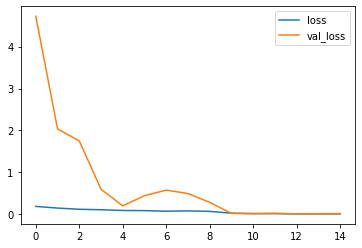

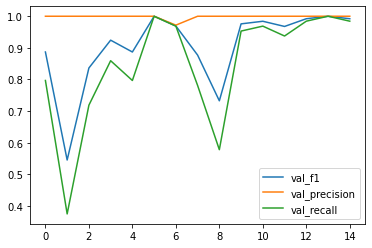

In [35]:
history_df = pd.DataFrame(history.history)
history_df['val_f1'] = metric.val_f1s
history_df['val_precision'] = metric.val_precisions
history_df['val_recall'] = metric.val_recalls
history_df[['loss','val_loss']].plot()
history_df[['val_f1','val_precision','val_recall']].plot()

In [36]:
test_generator.reset()

predictions = model.predict_generator(generator=test_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_generator.classes

In [37]:
from sklearn import metrics as m
print("Precision_weighted:",m.precision_score(y_test, y_pred, average="weighted")*100)
print("Recall_weighted:",m.recall_score(y_test, y_pred, average="weighted")*100)
print("F1_weighted:",m.f1_score(y_test, y_pred, average="weighted")*100)

Precision_weighted: 99.67325574688995
Recall_weighted: 99.67248908296943
F1_weighted: 99.67248722117752


In [38]:
labels_map = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels_map.items())
predict = [labels[k] for k in y_pred]
filenames = test_generator.filenames
results=pd.DataFrame({"Filename":filenames,"predictions":predict})

In [39]:
#confusion matrix
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y,predict_y):
     C = confusion_matrix(test_y,predict_y)
        
     print("Number of misclassified images-",(len(test_y)-np.trace(C)))
     print("% of misclassified images-",(len(test_y)-np.trace(C))*100/len(test_y))
     labels = [0,1,2,3,4,5,6,7,8,9]
     cmap=sns.light_palette("blue")
     print("-"*50, "Confusion matrix", "-"*50)
     plt.figure(figsize=(25,12))
     sns.heatmap(C, annot=True, cmap=cmap, fmt=".1f", xticklabels=labels,yticklabels=labels)
     plt.xlabel('predicted Class')
     plt.ylabel('Original Class')
     plt.show()

Number of misclassified images- 12
% of misclassified images- 0.32751091703056767
-------------------------------------------------- Confusion matrix --------------------------------------------------


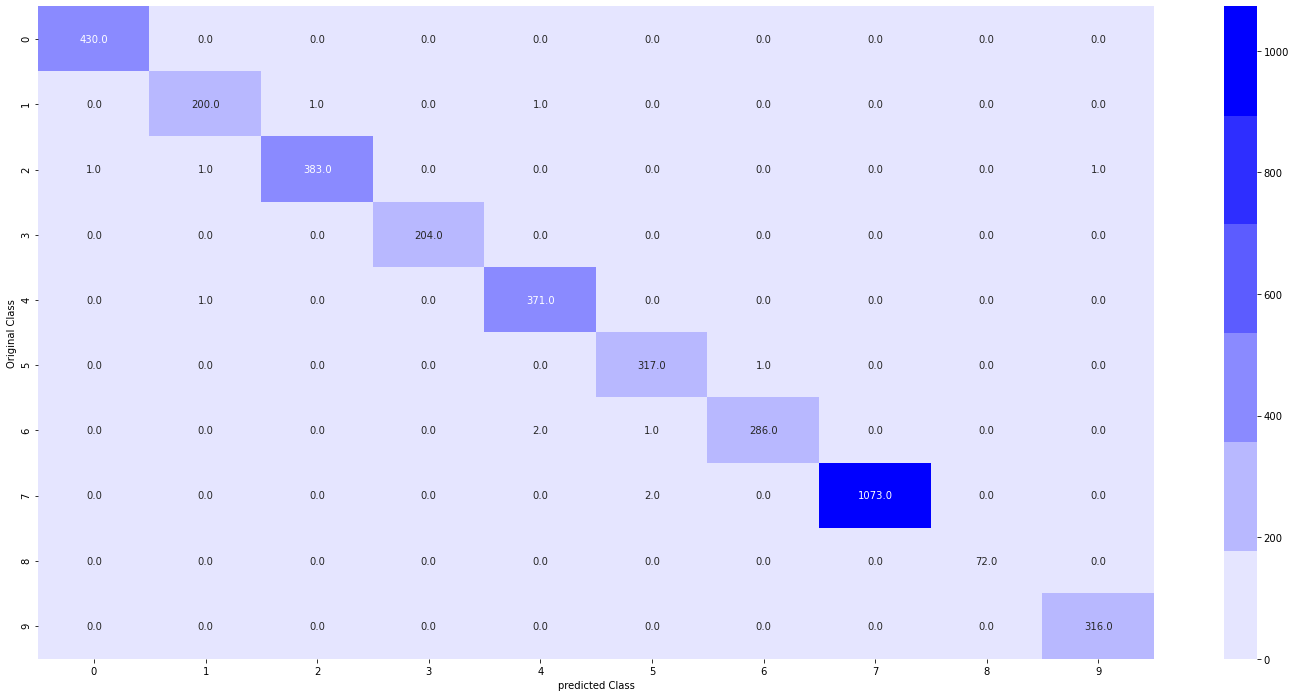

In [40]:
plot_confusion_matrix(y_test,y_pred)

In [41]:
def plot_recall_matrix(test_y,predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    labels = [0,1,2,3,4,5,6,7,8,9] 
    cmap=sns.light_palette("green")
    print("-"*50,"Recall matrix", "-"*50)
    plt.figure(figsize=(25,12))
    sns.heatmap(A,annot=True,cmap=cmap, fmt=".2f",xticklabels=labels,yticklabels=labels)
    plt.xlabel('predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("sum of rows in recall matrix",A.sum(axis=1))
        

-------------------------------------------------- Recall matrix --------------------------------------------------


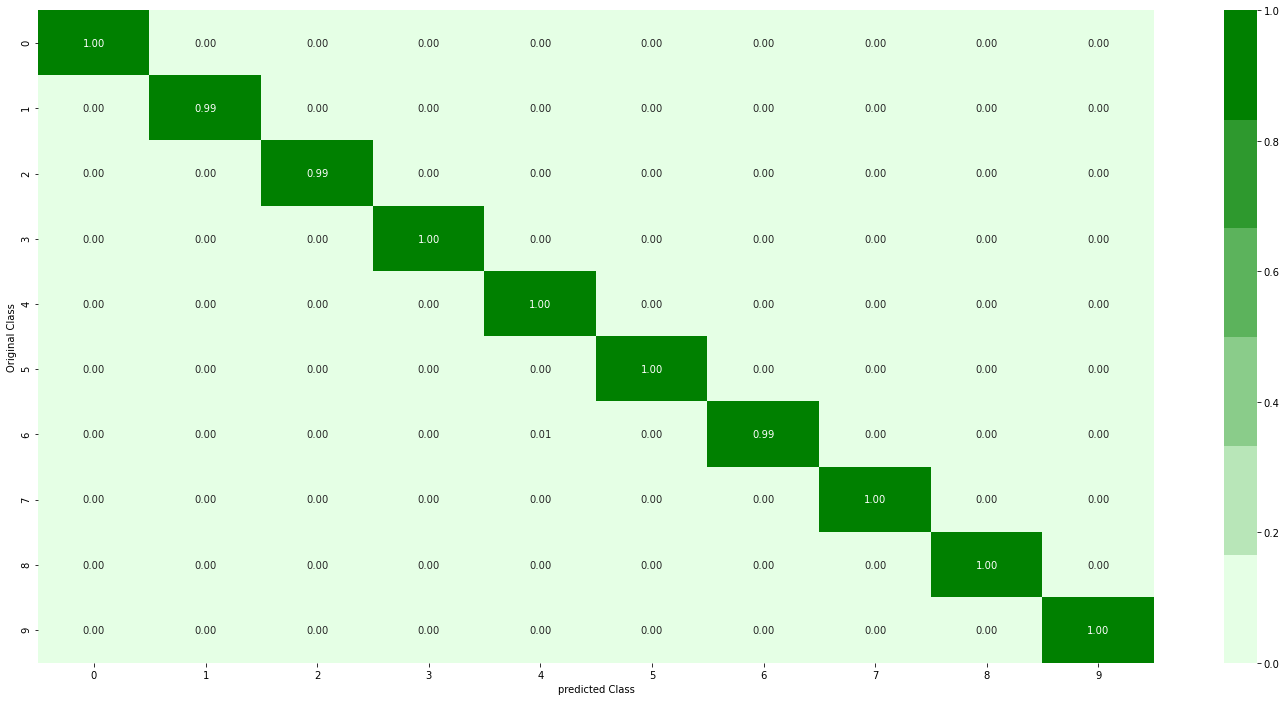

sum of rows in recall matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [42]:
plot_recall_matrix(y_test,y_pred)

In [43]:
def plot_precision_matrix(test_y,predict_y):
    C = confusion_matrix(test_y, predict_y)
    B =(C/C.sum(axis=0))
       
    labels = [0,1,2,3,4,5,6,7,8,9] 
    cmap=sns.light_palette("red")
    print("-"*50,"Precision matrix", "-"*50)
    plt.figure(figsize=(25,12))
    sns.heatmap(B,annot=True,cmap=cmap, fmt=".2f",xticklabels=labels,yticklabels=labels)
    plt.xlabel('predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("sum of rows in recall matrix",B.sum(axis=0))

-------------------------------------------------- Precision matrix --------------------------------------------------


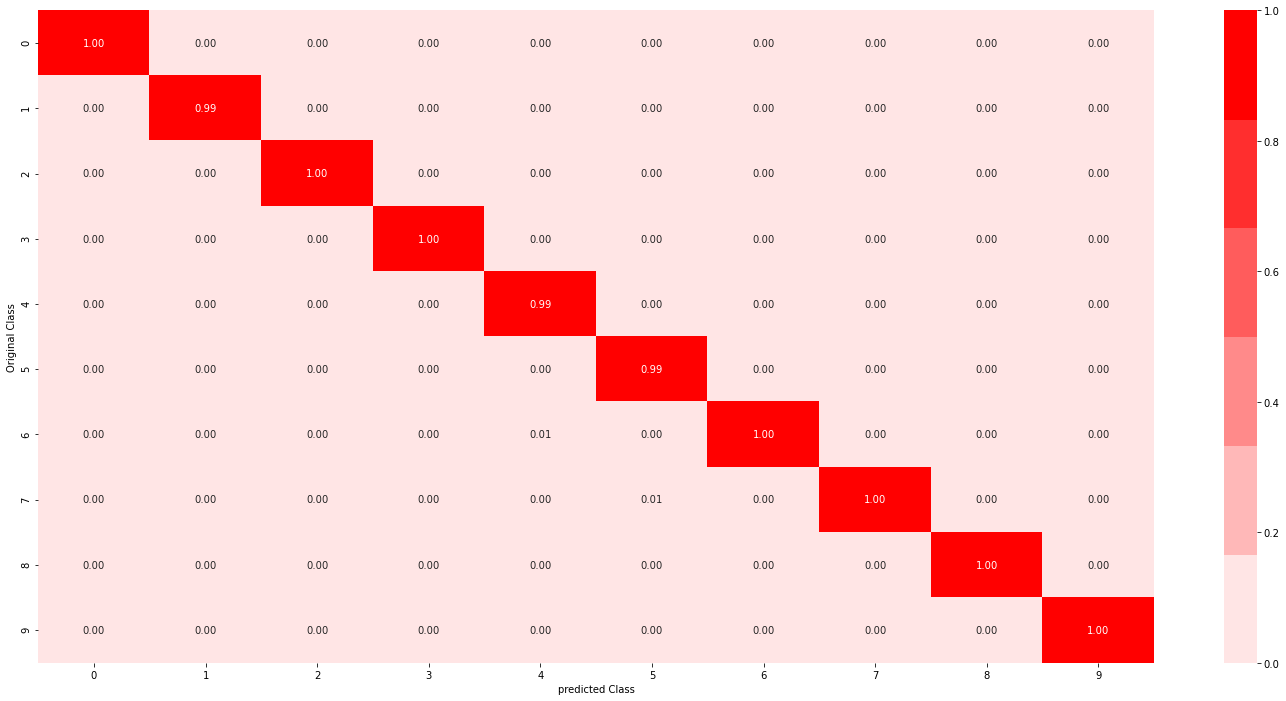

sum of rows in recall matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [44]:
plot_precision_matrix(y_test,y_pred)

In [47]:
def pred_img(file):
    np_image = Image.open(file)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (299, 299, 3))
    image = np.expand_dims(np_image, axis=0)
    pred=model.predict(image)
    k=np.argmax(pred,axis=1)
    clas=labels[k[0]]
    plt.imshow(plt.imread(file))
    plt.title("predicted:"+str(clas))
    plt.show()

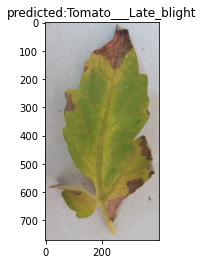

In [52]:
pred_img("C:/Users/Vijaya/Desktop/Predict_Images/my_tomato1.jpg")

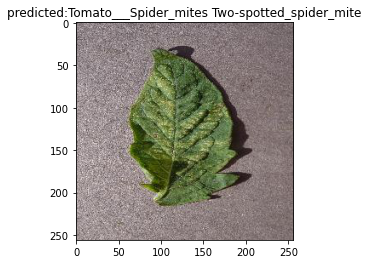

In [53]:
pred_img("C:/Users/Vijaya/Desktop/Predict_Images/mites.jpg")

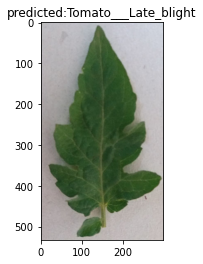

In [54]:
pred_img("C:/Users/Vijaya/Desktop/Predict_Images/my_tomato2.jpg")

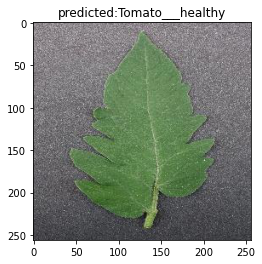

In [48]:
pred_img("C:/Users/Vijaya/Desktop/Predict_Images/tomato_healthy.jpg")

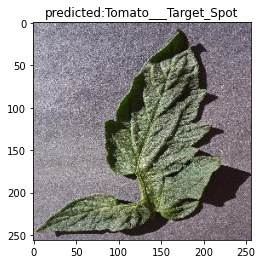

In [49]:
pred_img("C:/Users/Vijaya/Desktop/Predict_Images/tomato_healthy_1.jpg")

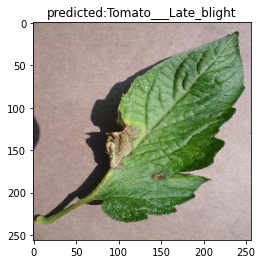

In [50]:
pred_img("C:/Users/Vijaya/Desktop/Predict_Images/tomato_late_blight.jpg")

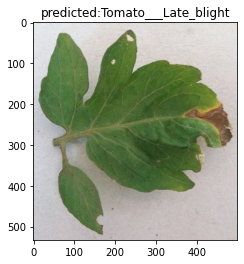

In [51]:
pred_img("C:/Users/Vijaya/Desktop/Predict_Images/my_tomato.jpg")

In [ ]:
'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'

In [3]:
%reload_ext autoreload
%autoreload 2 
%matplotlib inline


from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate,FBeta
from fastai.callback import *

In [1]:
data = ImageDataBunch.from_folder(path=data_dir,train='train', valid='test',ds_tfms=get_transforms(), size=256, bs=64)

NameError: name 'ImageDataLoaders' is not defined

In [2]:
import fastai
print(fastai.__version__)

2.0.7


In [3]:
from pathlib import Path

In [6]:
data = ImageDataBunch.from_df(path=data_dir,train='train', valid='test',ds_tfms=get_transforms(), size=256, bs=64)

NameError: name 'ImageDataBunch' is not defined

In [7]:
import fastai; fastai.__version__

'2.0.7'